In [11]:
# AutoGluon Time Series - Forecasting with Debugging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# For AutoGluon
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

# Optional for improved visualizations
import seaborn as sns
sns.set_style('whitegrid')

In [12]:
from QuestradeAPI import QuestradeAPI, Chronos

# Initialize components
api = QuestradeAPI()  # Handles authentication automatically
chronos = Chronos(api=api)  # Data caching and persistence layer

## 1. Data Loading and Exploration


In [25]:
# Load your stock data
df = chronos.get_all_market_data() # Your data should be loaded here
df.info()
# Add a new column for the target variable
df['target'] = df['close']



Converted start column to dtype: datetime64[ns]
Converted end column to dtype: datetime64[ns]
Retrieved 301638 total candles across all symbols
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301638 entries, 0 to 301637
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   symbol    301638 non-null  object        
 1   start     301638 non-null  datetime64[ns]
 2   end       301638 non-null  datetime64[ns]
 3   low       301638 non-null  float64       
 4   high      301638 non-null  float64       
 5   open      301638 non-null  float64       
 6   close     301638 non-null  float64       
 7   volume    301638 non-null  int64         
 8   VWAP      301638 non-null  float64       
 9   interval  301638 non-null  object        
dtypes: datetime64[ns](2), float64(5), int64(1), object(2)
memory usage: 23.0+ MB


In [26]:
# TimeSeriesDataFrame can also be loaded directly from a file
exemple_test_data = TimeSeriesDataFrame.from_path("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/test.csv")
exemple_train_data = TimeSeriesDataFrame.from_path("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/train.csv")


In [27]:
print(exemple_test_data.info())
print(exemple_train_data.info())

<class 'autogluon.timeseries.dataset.ts_dataframe.TimeSeriesDataFrame'>
MultiIndex: 157660 entries, ('H1', Timestamp('1750-01-01 00:00:00')) to ('H200', Timestamp('1750-02-11 23:00:00'))
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   target  157660 non-null  float64
dtypes: float64(1)
memory usage: 1.9+ MB
None
<class 'autogluon.timeseries.dataset.ts_dataframe.TimeSeriesDataFrame'>
MultiIndex: 148060 entries, ('H1', Timestamp('1750-01-01 00:00:00')) to ('H200', Timestamp('1750-02-09 23:00:00'))
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   target  148060 non-null  float64
dtypes: float64(1)
memory usage: 1.7+ MB
None


In [28]:
# Filter the data to keep only OneMinute intervals
df = df[df['interval'] == 'OneMinute']

# Display the first few rows to verify the filtering
print("Filtered data (OneMinute intervals only):")
df


Filtered data (OneMinute intervals only):


,symbol,start,end,low,high,open,close,volume,VWAP,interval,target
0,AAPL,2024-12-23 09:28:00,2024-12-23 09:29:00,255.5900,255.5900,255.5900,255.59,232,255.577901,OneMinute,255.59
1,AAPL,2024-12-23 09:30:00,2024-12-23 09:31:00,255.4900,255.6100,255.5400,255.61,400,255.554710,OneMinute,255.61
2,AAPL,2024-12-23 09:34:00,2024-12-23 09:35:00,255.5200,255.5700,255.5700,255.52,810,255.559809,OneMinute,255.52
3,AAPL,2024-12-23 09:37:00,2024-12-23 09:38:00,255.6300,255.6300,255.6300,255.63,270,255.569315,OneMinute,255.63
4,AAPL,2024-12-23 09:38:00,2024-12-23 09:39:00,255.7300,255.7300,255.7300,255.73,100,255.580754,OneMinute,255.73
...,...,...,...,...,...,...,...,...,...,...,...
301633,TSLA,2025-03-21 23:56:00,2025-03-21 23:57:00,249.2715,249.4000,249.3285,249.40,1988,243.559906,OneMinute,249.40
301634,TSLA,2025-03-21 23:57:00,2025-03-21 23:58:00,249.3300,249.4000,249.3300,249.39,4665,243.560211,OneMinute,249.39
301635,TSLA,2025-03-21 23:58:00,2025-03-21 23:59:00,249.3600,249.4001,249.4000,249.40,4519,243.560576,OneMinute,249.40
301636,TSLA,2025-03-21 23:59:00,2025-03-22 00:00:00,249.4000,249.4900,249.4004,249.45,9445,243.561199,OneMinute,249.45


In [29]:
# Add financial indicators to the dataframe
import pandas as pd
import numpy as np

# Create a copy of the dataframe to avoid modifying the original
df_with_indicators = df.copy()

# Group by symbol to calculate indicators for each stock separately
for symbol in df_with_indicators['symbol'].unique():
    symbol_data = df_with_indicators[df_with_indicators['symbol'] == symbol].sort_values('start')
    
    # Moving Averages
    df_with_indicators.loc[symbol_data.index, 'MA_5'] = symbol_data['close'].rolling(window=5).mean()
    df_with_indicators.loc[symbol_data.index, 'MA_20'] = symbol_data['close'].rolling(window=20).mean()
    
    # Relative Strength Index (RSI)
    delta = symbol_data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df_with_indicators.loc[symbol_data.index, 'RSI'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands
    middle_band = symbol_data['close'].rolling(window=20).mean()
    std_dev = symbol_data['close'].rolling(window=20).std()
    df_with_indicators.loc[symbol_data.index, 'BB_Upper'] = middle_band + (std_dev * 2)
    df_with_indicators.loc[symbol_data.index, 'BB_Lower'] = middle_band - (std_dev * 2)
    
    # MACD (Moving Average Convergence Divergence)
    ema_12 = symbol_data['close'].ewm(span=12, adjust=False).mean()
    ema_26 = symbol_data['close'].ewm(span=26, adjust=False).mean()
    df_with_indicators.loc[symbol_data.index, 'MACD'] = ema_12 - ema_26
    df_with_indicators.loc[symbol_data.index, 'MACD_Signal'] = (ema_12 - ema_26).ewm(span=9, adjust=False).mean()
    
    # Average True Range (ATR)
    high_low = symbol_data['high'] - symbol_data['low']
    high_close = abs(symbol_data['high'] - symbol_data['close'].shift())
    low_close = abs(symbol_data['low'] - symbol_data['close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df_with_indicators.loc[symbol_data.index, 'ATR'] = true_range.rolling(window=14).mean()

# Replace the original dataframe with the one containing indicators
df = df_with_indicators

# Display the first few rows to verify the indicators were added
print("Data with financial indicators:")
df.head()


Data with financial indicators:


,symbol,start,end,low,high,open,close,volume,VWAP,interval,target,MA_5,MA_20,RSI,BB_Upper,BB_Lower,MACD,MACD_Signal,ATR
0,AAPL,2024-12-23 09:28:00,2024-12-23 09:29:00,255.59,255.59,255.59,255.59,232,255.577901,OneMinute,255.59,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,AAPL,2024-12-23 09:30:00,2024-12-23 09:31:00,255.49,255.61,255.54,255.61,400,255.554710,OneMinute,255.61,NaN,NaN,NaN,NaN,NaN,0.001595,0.000319,NaN
2,AAPL,2024-12-23 09:34:00,2024-12-23 09:35:00,255.52,255.57,255.57,255.52,810,255.559809,OneMinute,255.52,NaN,NaN,NaN,NaN,NaN,-0.004352,-0.000615,NaN
3,AAPL,2024-12-23 09:37:00,2024-12-23 09:38:00,255.63,255.63,255.63,255.63,270,255.569315,OneMinute,255.63,NaN,NaN,NaN,NaN,NaN,-0.000188,-0.000530,NaN
4,AAPL,2024-12-23 09:38:00,2024-12-23 09:39:00,255.73,255.73,255.73,255.73,100,255.580754,OneMinute,255.73,255.616,NaN,NaN,NaN,NaN,0.011055,0.001787,NaN


In [30]:
# Complete code to convert your DataFrame to AutoGluon TimeSeriesDataFrame format
from autogluon.timeseries import TimeSeriesDataFrame
import pandas as pd

# Step 1: Create a copy of your original dataframe
df_ts = df.copy()

# Step 2: Rename columns to match AutoGluon's requirements
df_ts = df_ts.rename(columns={
    'symbol': 'item_id',   # Stock symbol becomes item_id
    'start': 'timestamp'   # Start time becomes timestamp
})

# Step 3: Set target column (what you want to predict)
# Here we'll use 'close' as the target, but you can change this to any column
df_ts['target'] = df_ts['close']

# Step 4: Make sure the dataframe is sorted properly
df_ts = df_ts.sort_values(['item_id', 'timestamp']).reset_index(drop=True)

# Step 5: Create the TimeSeriesDataFrame
ts_data = TimeSeriesDataFrame.from_data_frame(
    df_ts,
    id_column='item_id',
    timestamp_column='timestamp'
)

# Step 6: Define prediction length and create train/test split
prediction_length = 60  # Number of candles to predict (and exclude from training)

# Print information about the full dataset
print("Full dataset information:")
print(f"Shape: {ts_data.shape}")
print(f"Number of stocks: {len(ts_data.item_ids)}")
print(f"Columns: {ts_data.columns.tolist()}")
print(f"Item IDs: {list(ts_data.item_ids)}")

# Step 7: Create proper train/test split
# Create a dictionary to store the filtered groups
filtered_groups = {}

# Process each stock separately to ensure linear data
for item_id, group in ts_data.groupby('item_id'):
    # Sort by timestamp to ensure data is in chronological order
    group = group.sort_index(level='timestamp')
    
    # Verify the data is properly sorted
    timestamps = group.index.get_level_values('timestamp')
    is_sorted = all(timestamps[i] <= timestamps[i+1] for i in range(len(timestamps)-1))
    if not is_sorted:
        print(f"WARNING: Timestamps for {item_id} are not in order!")
    
    # Calculate the training cutoff point (all except last prediction_length points)
    train_size = max(0, len(group) - prediction_length)
    
    # Store the filtered group
    filtered_groups[item_id] = group
    
# Step 8: Create the training dataset by excluding the last prediction_length points
train_data = TimeSeriesDataFrame.from_data_frame(
    pd.concat([
        group.iloc[:-prediction_length] 
        for item_id, group in filtered_groups.items()
    ])
)

# Test data is the complete dataset
test_data = ts_data.copy()

# Print information about the datasets
print("\nTraining and testing data information:")
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# Step 9: Verify that each stock has sufficient data
for item_id in ts_data.item_ids:
    # Get the number of points for this stock
    train_count = len(train_data.loc[item_id]) if item_id in train_data.item_ids else 0
    test_count = len(test_data.loc[item_id])
    
    # Print the counts
    print(f"Stock {item_id}: {train_count} training points, {test_count} total points")
    
    # Check if we have enough training data
    min_required = prediction_length + 10  # Need at least prediction_length + some history
    if train_count < min_required:
        print(f"  WARNING: Stock {item_id} has only {train_count} training points, " 
              f"which is less than the recommended {min_required}")

# Step 10: Sample the data to verify it looks correct
print("\nSample of training data (first 5 rows of first stock):")
first_stock = train_data.item_ids[0]
print(train_data.loc[first_stock].head(5))

print("\nSample of test data (last 5 rows of first stock):")
print(test_data.loc[first_stock].tail(5))

# Step 11: Check for any missing values that might cause issues
missing_count = train_data.isna().sum()
if missing_count.sum() > 0:
    print("\nWARNING: Training data contains missing values:")
    print(missing_count[missing_count > 0])
else:
    print("\nNo missing values found in training data.")

# Step 12: Verify time differences to ensure data is properly spaced
for item_id in list(train_data.item_ids)[:2]:  # Check first two stocks
    print(f"\nChecking time differences for {item_id}:")
    timestamps = train_data.loc[item_id].index.get_level_values('timestamp')
    time_diffs = timestamps[1:] - timestamps[:-1]
    
    # Show the most common time differences
    common_diffs = pd.Series(time_diffs).value_counts().head(3)
    print(f"Most common time differences: {common_diffs}")

# Step 13: Detect the frequency from the data
sample_timestamps = train_data.loc[first_stock].index.get_level_values('timestamp')
time_diffs = sample_timestamps[1:] - sample_timestamps[:-1]
median_diff = pd.Timedelta(time_diffs.median())
print(f"\nMedian time difference: {median_diff}")

# Convert to a frequency string for AutoGluon
# This will be used in the TimeSeriesPredictor
if median_diff == pd.Timedelta(minutes=1):
    freq = '1min'
elif median_diff == pd.Timedelta(minutes=5):
    freq = '5min'
elif median_diff == pd.Timedelta(hours=1):
    freq = '1H'
elif median_diff == pd.Timedelta(days=1):
    freq = '1D'
else:
    freq = f"{int(median_diff.total_seconds())}s"

print(f"Detected frequency: {freq}")

# Return both train_data and test_data
print("\nData preparation complete. Ready for AutoGluon training!")


Full dataset information:
Shape: (301638, 17)
Number of stocks: 7
Columns: ['end', 'low', 'high', 'open', 'close', 'volume', 'VWAP', 'interval', 'target', 'MA_5', 'MA_20', 'RSI', 'BB_Upper', 'BB_Lower', 'MACD', 'MACD_Signal', 'ATR']
Item IDs: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']

Training and testing data information:
Training data shape: (301218, 17)
Testing data shape: (301638, 17)
Stock AAPL: 42074 training points, 42134 total points
Stock AMZN: 42007 training points, 42067 total points
Stock GOOGL: 38624 training points, 38684 total points
Stock META: 34725 training points, 34785 total points
Stock MSFT: 35238 training points, 35298 total points
Stock NVDA: 55174 training points, 55234 total points
Stock TSLA: 53376 training points, 53436 total points

Sample of training data (first 5 rows of first stock):
                                    end     low    high    open   close  \
timestamp                                                                 
2024-12

In [31]:
train_data


end     low    high      open  \
item_id timestamp                                                           
AAPL    2024-12-23 09:28:00 2024-12-23 09:29:00  255.59  255.59  255.5900   
        2024-12-23 09:30:00 2024-12-23 09:31:00  255.49  255.61  255.5400   
        2024-12-23 09:34:00 2024-12-23 09:35:00  255.52  255.57  255.5700   
        2024-12-23 09:37:00 2024-12-23 09:38:00  255.63  255.63  255.6300   
        2024-12-23 09:38:00 2024-12-23 09:39:00  255.73  255.73  255.7300   
...                                         ...     ...     ...       ...   
TSLA    2025-03-21 22:56:00 2025-03-21 22:57:00  249.50  249.60  249.5500   
        2025-03-21 22:57:00 2025-03-21 22:58:00  249.56  249.68  249.6745   
        2025-03-21 22:58:00 2025-03-21 22:59:00  249.65  249.69  249.6700   
        2025-03-21 22:59:00 2025-03-21 23:00:00  249.68  249.73  249.6800   
        2025-03-21 23:00:00 2025-03-21 23:01:00  249.75  249.78  249.7500   

                              close  volume        VWAP   interval  target  \
item_id timestamp                                                            
AAPL    2024-12-23 09:28:00  255.59     232  255.577901  OneMinute  255.59   
        2024-12-23 09:30:00  255.61     400  255.554710  OneMinute  255.61   
        2024-12-23 09:34:00  255.52     810  255.559809  OneMinute  255.52   
        2024-12-23 09:37:00  255.63     270  255.569315  OneMinute  255.63   
        2024-12-23 09:38:00  255.73     100  255.580754  OneMinute  255.73   
...                             ...     ...         ...        ...     ...   
TSLA    2025-03-21 22:56:00  249.60    2529  243.559069  OneMinute  249.60   
        2025-03-21 22:57:00  249.68    1435  243.559183  OneMinute  249.68   
        2025-03-21 22:58:00  249.69    1797  243.559318  OneMinute  249.69   
        2025-03-21 22:59:00  249.73     203  243.559396  OneMinute  249.73   
        2025-03-21 23:00:00  249.78     300  243.559497  OneMinute  249.78   

                                  MA_5       MA_20        RSI    BB_Upper  \
item_id timestamp                                                           
AAPL    2024-12-23 09:28:00        NaN         NaN        NaN         NaN   
        2024-12-23 09:30:00        NaN         NaN        NaN         NaN   
        2024-12-23 09:34:00        NaN         NaN        NaN         NaN   
        2024-12-23 09:37:00        NaN         NaN        NaN         NaN   
        2024-12-23 09:38:00  255.61600         NaN        NaN         NaN   
...                                ...         ...        ...         ...   
TSLA    2025-03-21 22:56:00  249.55404  249.610045  38.017586  249.766624   
        2025-03-21 22:57:00  249.58804  249.609545  50.799233  249.765109   
        2025-03-21 22:58:00  249.62200  249.608545  57.792666  249.761628   
        2025-03-21 22:59:00  249.65200  249.615045  57.158196  249.777361   
        2025-03-21 23:00:00  249.69600  249.622545  59.341033  249.800846   

                               BB_Lower      MACD  MACD_Signal       ATR  
item_id timestamp                                                         
AAPL    2024-12-23 09:28:00         NaN  0.000000     0.000000       NaN  
        2024-12-23 09:30:00         NaN  0.001595     0.000319       NaN  
        2024-12-23 09:34:00         NaN -0.004352    -0.000615       NaN  
        2024-12-23 09:37:00         NaN -0.000188    -0.000530       NaN  
        2024-12-23 09:38:00         NaN  0.011055     0.001787       NaN  
...                                 ...       ...          ...       ...  
TSLA    2025-03-21 22:56:00  249.453466  0.012608     0.028216  0.075271  
        2025-03-21 22:57:00  249.453981  0.020292     0.026631  0.075271  
        2025-03-21 22:58:00  249.455462  0.026879     0.026681  0.068843  
        2025-03-21 22:59:00  249.452729  0.034924     0.028329  0.066100  
        2025-03-21 23:00:00  249.444244  0.044818     0.031627  0.065386  

[301218 rows x 17 columns]

In [32]:
test_data

end       low      high      open  \
item_id timestamp                                                               
AAPL    2024-12-23 09:28:00 2024-12-23 09:29:00  255.5900  255.5900  255.5900   
        2024-12-23 09:30:00 2024-12-23 09:31:00  255.4900  255.6100  255.5400   
        2024-12-23 09:34:00 2024-12-23 09:35:00  255.5200  255.5700  255.5700   
        2024-12-23 09:37:00 2024-12-23 09:38:00  255.6300  255.6300  255.6300   
        2024-12-23 09:38:00 2024-12-23 09:39:00  255.7300  255.7300  255.7300   
...                                         ...       ...       ...       ...   
TSLA    2025-03-21 23:56:00 2025-03-21 23:57:00  249.2715  249.4000  249.3285   
        2025-03-21 23:57:00 2025-03-21 23:58:00  249.3300  249.4000  249.3300   
        2025-03-21 23:58:00 2025-03-21 23:59:00  249.3600  249.4001  249.4000   
        2025-03-21 23:59:00 2025-03-22 00:00:00  249.4000  249.4900  249.4004   
        2025-03-22 00:00:00 2025-03-22 00:01:00  249.4500  249.4500  249.4500   

                              close  volume        VWAP   interval  target  \
item_id timestamp                                                            
AAPL    2024-12-23 09:28:00  255.59     232  255.577901  OneMinute  255.59   
        2024-12-23 09:30:00  255.61     400  255.554710  OneMinute  255.61   
        2024-12-23 09:34:00  255.52     810  255.559809  OneMinute  255.52   
        2024-12-23 09:37:00  255.63     270  255.569315  OneMinute  255.63   
        2024-12-23 09:38:00  255.73     100  255.580754  OneMinute  255.73   
...                             ...     ...         ...        ...     ...   
TSLA    2025-03-21 23:56:00  249.40    1988  243.559906  OneMinute  249.40   
        2025-03-21 23:57:00  249.39    4665  243.560211  OneMinute  249.39   
        2025-03-21 23:58:00  249.40    4519  243.560576  OneMinute  249.40   
        2025-03-21 23:59:00  249.45    9445  243.561199  OneMinute  249.45   
        2025-03-22 00:00:00  249.45     200  243.561199  OneMinute  249.45   

                                  MA_5       MA_20        RSI    BB_Upper  \
item_id timestamp                                                           
AAPL    2024-12-23 09:28:00        NaN         NaN        NaN         NaN   
        2024-12-23 09:30:00        NaN         NaN        NaN         NaN   
        2024-12-23 09:34:00        NaN         NaN        NaN         NaN   
        2024-12-23 09:37:00        NaN         NaN        NaN         NaN   
        2024-12-23 09:38:00  255.61600         NaN        NaN         NaN   
...                                ...         ...        ...         ...   
TSLA    2025-03-21 23:56:00  249.23162  249.101970  62.888496  249.441728   
        2025-03-21 23:57:00  249.29962  249.107470  63.355097  249.462578   
        2025-03-21 23:58:00  249.32800  249.107655  67.608389  249.463399   
        2025-03-21 23:59:00  249.38800  249.116155  74.349170  249.496511   
        2025-03-22 00:00:00  249.41800  249.129155  70.821766  249.536923   

                               BB_Lower      MACD  MACD_Signal       ATR  
item_id timestamp                                                         
AAPL    2024-12-23 09:28:00         NaN  0.000000     0.000000       NaN  
        2024-12-23 09:30:00         NaN  0.001595     0.000319       NaN  
        2024-12-23 09:34:00         NaN -0.004352    -0.000615       NaN  
        2024-12-23 09:37:00         NaN -0.000188    -0.000530       NaN  
        2024-12-23 09:38:00         NaN  0.011055     0.001787       NaN  
...                                 ...       ...          ...       ...  
TSLA    2025-03-21 23:56:00  248.762212 -0.043496    -0.104235  0.140371  
        2025-03-21 23:57:00  248.752362 -0.021952    -0.087779  0.132029  
        2025-03-21 23:58:00  248.751911 -0.004025    -0.071028  0.122036  
        2025-03-21 23:59:00  248.735799  0.014055    -0.054011  0.119893  
        2025-03-22 00:00:00  248.721387  0.028060    -0.037597  0.109179 

In [33]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    path="../models/test",
    target="target",
    eval_metric="RMSE",
    freq="min",
    known_covariates_names=['MA_5', 'MA_20', 'RSI', 'BB_Upper', 'BB_Lower', 'MACD', 'MACD_Signal', 'ATR']

)

predictor.fit(
    train_data,
    presets="fast_training",
    time_limit=600,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'c:\Users\yaloo\QuestradeCustomWrapper\models\test'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          22
GPU Count:          0
Memory Avail:       1.64 GB / 15.37 GB (10.7%)
Disk Space Avail:   528.95 GB / 951.93 GB (55.6%)
Setting presets to: fast_training

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'freq': 'min',
 'hyperparameters': 'very_light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 60,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'min'.

In [36]:
predictions = predictor.predict(train_data)
predictions.head()

data with frequency 'None' has been resampled to frequency 'min'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id timestamp                                                             
AAPL    2025-03-21 22:02:00  218.599869  216.747620  217.383461  217.841947   
        2025-03-21 22:03:00  218.732422  216.112936  217.012151  217.660548   
        2025-03-21 22:04:00  218.558304  215.350093  216.451402  217.245524   
        2025-03-21 22:05:00  218.596420  214.891903  216.163585  217.080558   
        2025-03-21 22:06:00  218.596375  214.454606  215.876390  216.901596   

                                    0.4         0.5         0.6         0.7  \
item_id timestamp                                                             
AAPL    2025-03-21 22:02:00  218.233706  218.599875  218.966043  219.357802   
        2025-03-21 22:03:00  218.214580  218.732420  219.250260  219.804292   
        2025-03-21 22:04:00  217.924071  218.558293  219.192515  219.871062   
        2025-03-21 22:05:00  217.864077  218.596413  219.328750  220.112269   
        2025-03-21 22:06:00  217.777597  218.596374  219.415151  220.291152   

                                    0.8         0.9  
item_id timestamp                                    
AAPL    2025-03-21 22:02:00  219.816289  220.452130  
        2025-03-21 22:03:00  220.452689  221.351904  
        2025-03-21 22:04:00  220.665184  221.766493  
        2025-03-21 22:05:00  221.029241  222.300923  
        2025-03-21 22:06:00  221.316358  222.738142

data with frequency 'None' has been resampled to frequency 'min'.


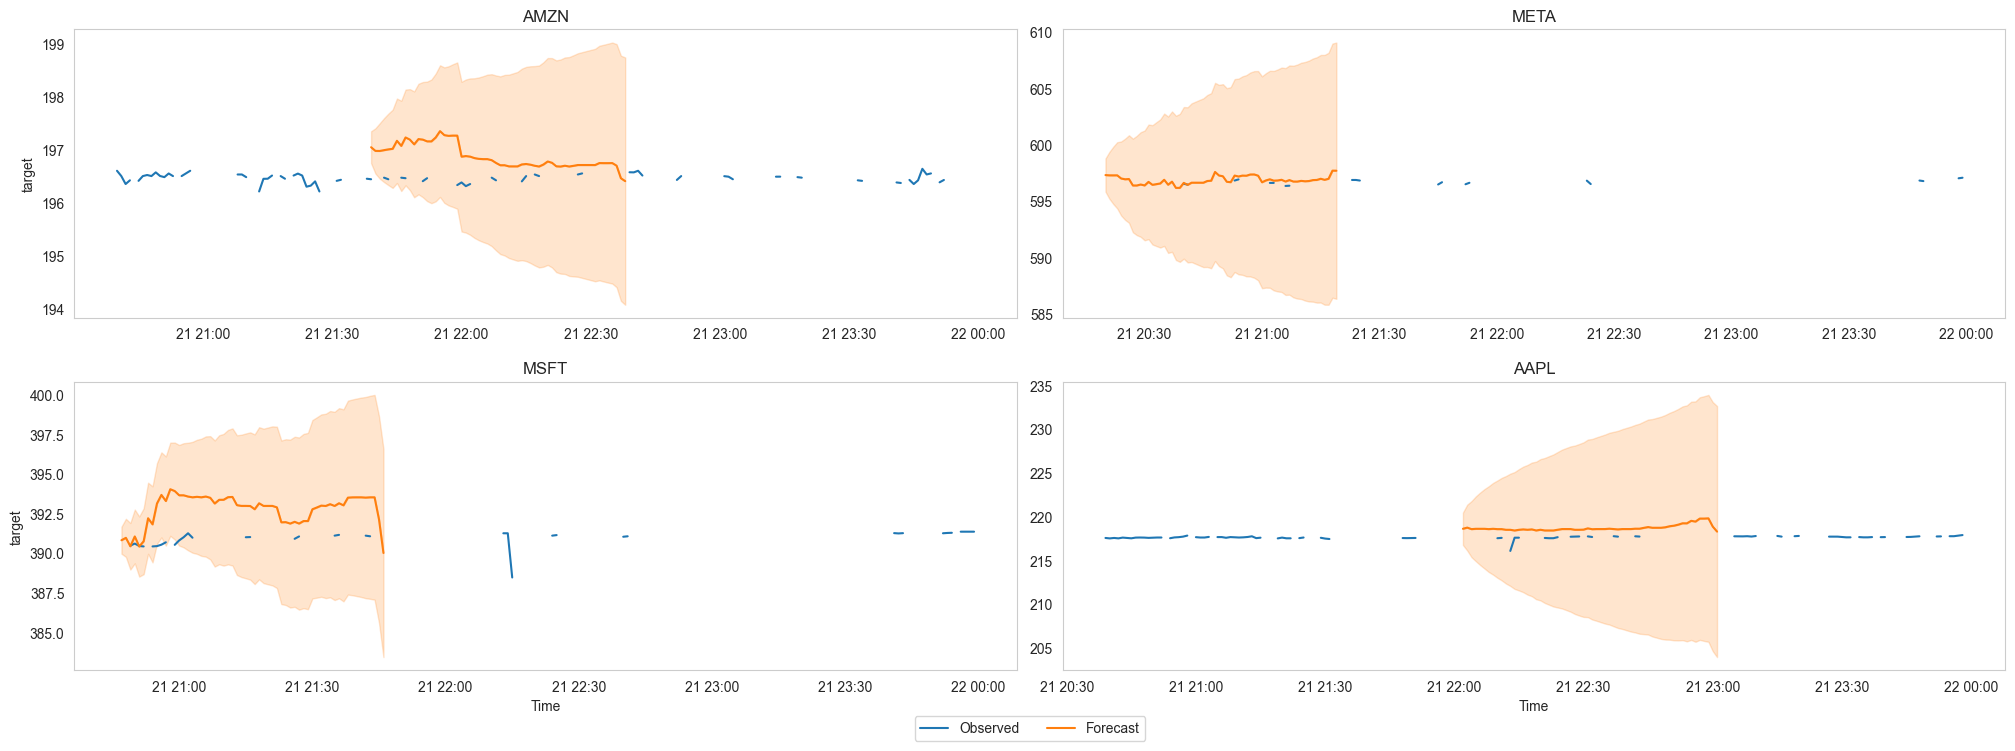

In [37]:
# Plot 4 randomly chosen time series and the respective forecasts
plot_data = predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4);
plot_data 


In [38]:
# The test score is computed using the last
# prediction_length=48 timesteps of each time series in test_data
predictor.leaderboard(test_data)

data with frequency 'None' has been resampled to frequency 'min'.


Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ETS,-0.234000,-1.984173,5.830436,2.718523,1.186420,5
1,Naive,-0.235870,-1.982919,0.125555,3.534696,0.757079,1
2,Theta,-0.267476,-1.989576,27.592930,27.505361,1.101288,6
3,RecursiveTabular,-0.284630,-2.406422,2.052371,2.088456,8.830310,3
4,WeightedEnsemble,-0.922607,-1.505336,3.030649,3.066811,0.648630,7
5,DirectTabular,-0.936330,-1.505533,0.975279,0.978355,8.873615,4
6,SeasonalNaive,-7.893023,-7.012037,0.162064,2.478691,0.808751,2


data with frequency 'None' has been resampled to frequency 'min'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
data with frequency 'None' has been resampled to frequency 'min'.


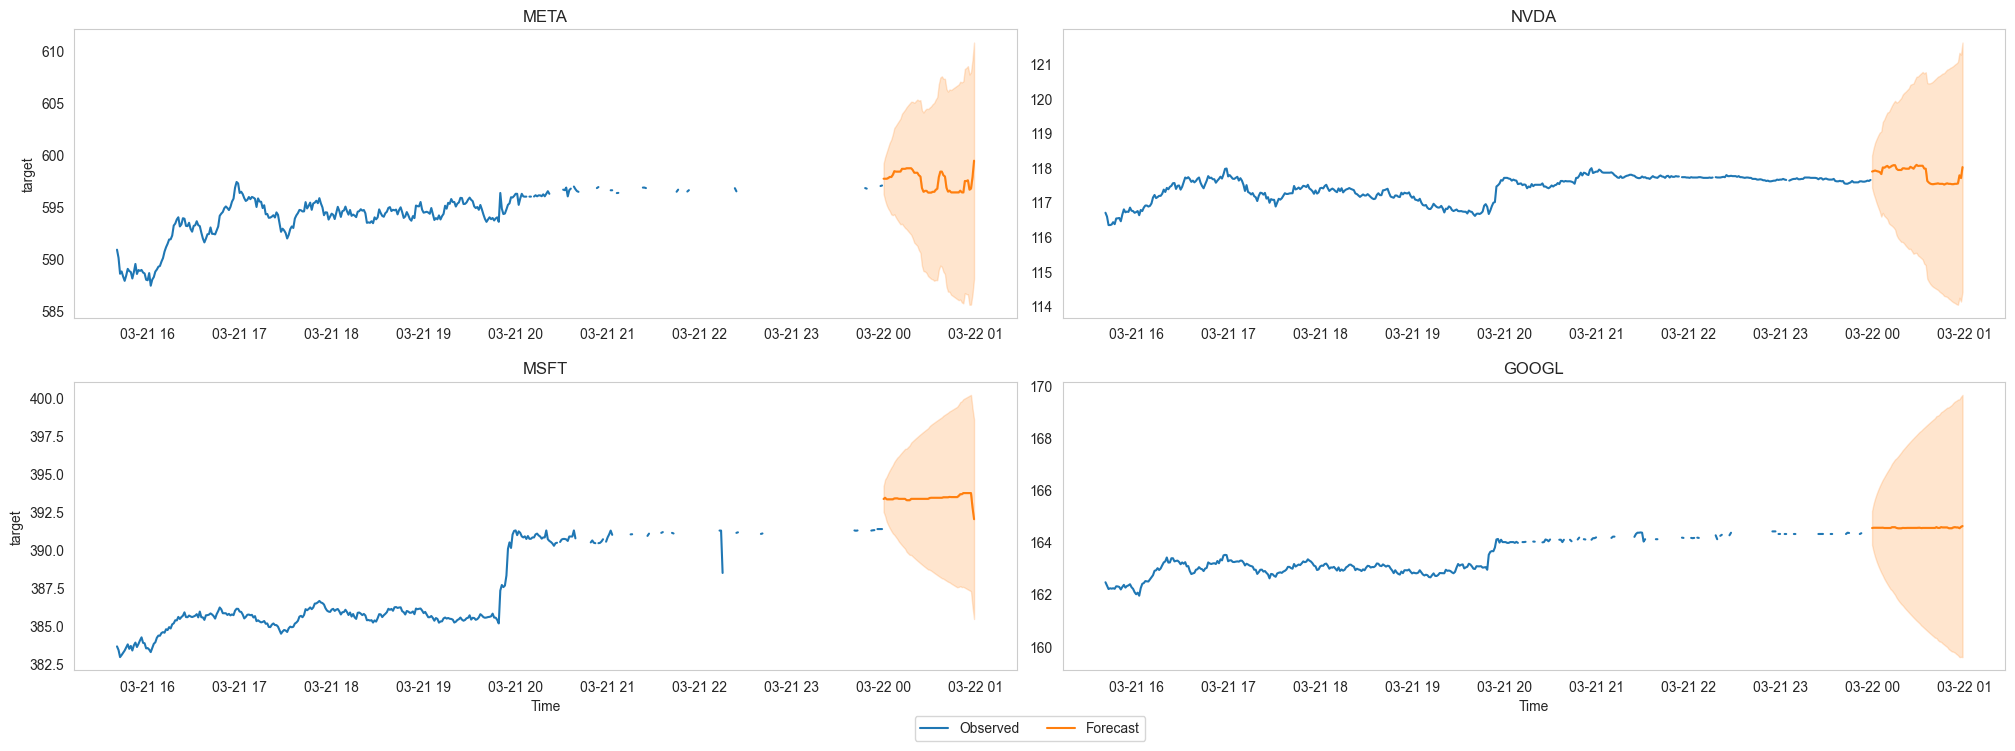

In [41]:
new_predictor = predictor.predict(test_data)
plot_data = predictor.plot(test_data, new_predictor, quantile_levels=[0.1, 0.9], max_history_length=500, max_num_item_ids=4);
plot_data 
